<a href="https://colab.research.google.com/github/rohithv-21/Case-Study---Fast-food/blob/main/Case_Study_Fast_Food_(Mc_Donalds)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from statsmodels.graphics.mosaicplot import mosaic


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MD = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Internship(Feynn Labs)/mcdonalds.csv")

#Exploring Data

In [4]:
MD.columns

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

In [5]:
MD.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


In [9]:
MD_x = MD.iloc[:, 0:11].apply(lambda x: (x == "Yes") * 1)

np.round(MD.x.mean(), 2)

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

In [11]:
# Assuming MD_x is a numpy array or pandas DataFrame containing the binary data
MD_pca = PCA().fit(MD_x)

# Print summary
print("Standard deviations:\n", np.round(MD.pca.explained_variance_, 3))
print("\nProportion of Variance:\n", np.round(MD.pca.explained_variance_ratio_, 3))
print("\nCumulative Proportion:\n", np.round(MD_pca.explained_variance_ratio_.cumsum(), 3))
print("\nLoadings:\n", pd.DataFrame(np.round(MD_pca.components_.T, 3), columns=['PC{}'.format(i) for i in range(1, MD_x.shape[1]+1)], index=MD_x.columns))


Standard deviations:
 [0.573 0.369 0.255 0.159 0.114 0.096 0.084 0.076 0.07  0.062 0.056]

Proportion of Variance:
 [0.299 0.193 0.133 0.083 0.059 0.05  0.044 0.04  0.037 0.032 0.029]

Cumulative Proportion:
 [0.299 0.492 0.625 0.708 0.768 0.818 0.862 0.902 0.938 0.971 1.   ]

Loadings:
               PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9  \
yummy      -0.477  0.364 -0.304  0.055 -0.308  0.171 -0.281  0.013  0.572   
convenient -0.155  0.016 -0.063 -0.142  0.278 -0.348 -0.060 -0.113 -0.018   
spicy      -0.006  0.019 -0.037  0.198  0.071 -0.355  0.708  0.376  0.400   
fattening   0.116 -0.034 -0.322 -0.354 -0.073 -0.407 -0.386  0.590 -0.161   
greasy      0.304 -0.064 -0.802  0.254  0.361  0.209  0.036 -0.138 -0.003   
fast       -0.108 -0.087 -0.065 -0.097  0.108 -0.595 -0.087 -0.628  0.166   
cheap      -0.337 -0.611 -0.149  0.119 -0.129 -0.103 -0.040  0.140  0.076   
tasty      -0.472  0.307 -0.287 -0.003 -0.211 -0.077  0.360 -0.073 -0.639   
expensive   0.329 

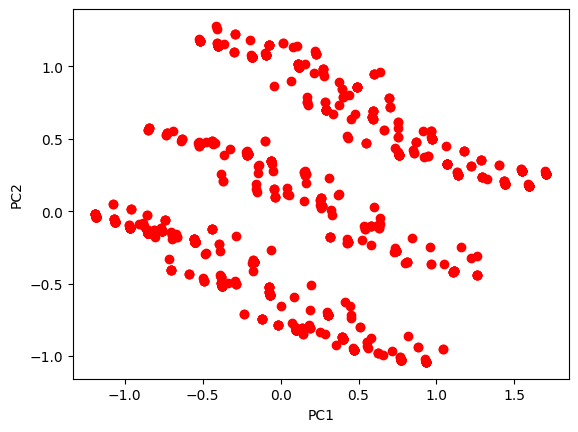

In [12]:
# Project data onto first two principal components
proj = MD.pca.transform(MD.x)[:, :2]

# Create scatter plot of projected data
plt.scatter(proj[:, 0], proj[:, 1], c='red')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#Extracting Segments
Using k-Means

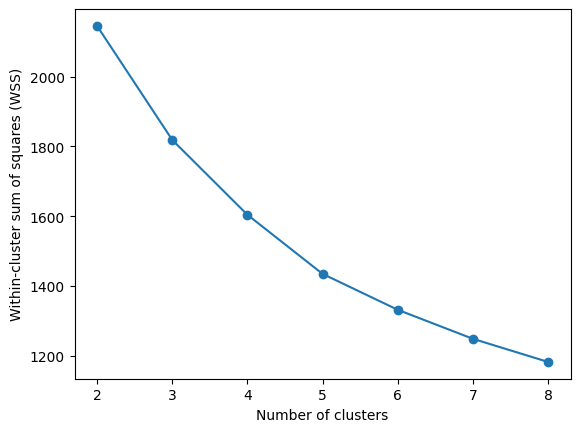

In [13]:
# Set the seed for reproducibility
np.random.seed(1234)

# Define the range of cluster numbers to try
n_clusters = range(2, 9)

# Perform k-means clustering with 10 random restarts for each number of clusters
MD_kms = []
wss = []
for k in n_clusters:
    km = KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD.x)
    MD_kms.append(km)
    wss.append(km.inertia_)

# Relabel the cluster numbers to be consistent across segmentations
def relabel_clusters(km_list):
    relabeled_list = []
    for i, km in enumerate(km_list):
        labels = km.labels_
        num_clusters = len(np.unique(labels))
        new_labels = np.zeros_like(labels)
        for j in range(num_clusters):
            mask = labels == j
            mode = np.bincount(labels[mask]).argmax()
            new_labels[mask] = mode + i * num_clusters
        relabeled_km = km.__class__(**km.get_params())
        relabeled_km.labels_ = new_labels
        relabeled_list.append(relabeled_km)
    return relabeled_list

MD_kms_relabeled = relabel_clusters(MD_kms)

# Plot the WSS for each clustering solution
import matplotlib.pyplot as plt

plt.plot(n_clusters, wss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares (WSS)')
plt.show()

In [14]:
# Set the seed for reproducibility
np.random.seed(1234)

# Define the range of cluster numbers to try
n_clusters = range(2, 9)

# Perform bootstrapped clustering with 10 random restarts for each number of clusters
MD_kms = []
boot_ARIs = []
for k in n_clusters:
    ARI_boot = []
    for b in range(100):
        boot_data = resample(MD.x, random_state=b)
        km = KMeans(n_clusters=k, n_init=10, random_state=1234).fit(boot_data)
        MD_kms.append(km)
        true_labels = np.repeat(np.arange(k), len(boot_data) // k + 1)[:len(boot_data)]
        ARI = adjusted_rand_score(true_labels, km.labels_)
        ARI_boot.append(ARI)
    boot_ARIs.append(np.mean(ARI_boot))

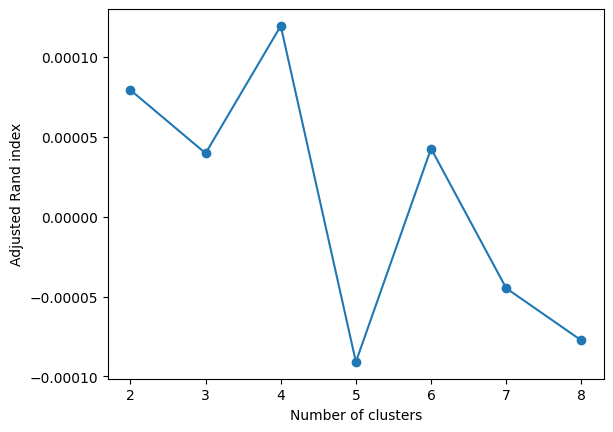

In [15]:
# Plot the adjusted Rand index for each clustering solution
plt.plot(n_clusters, boot_ARIs, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand index')
plt.show()

 Using Mixtures of Regression Models

In [16]:
# Count the frequency of each level in the 'Like' column
freq = pd.value_counts(MD['Like'])

# Reverse the order of the frequency table
rev_freq = freq.iloc[::-1]

# Print the reversed frequency table
print(rev_freq)

-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: Like, dtype: int64


In [17]:
# Extract the numeric part of each 'Like' value and convert it to integer
MD['Like.n'] = pd.to_numeric(MD['Like'], errors='coerce')
MD['Like.n'] = 6 - MD['Like.n']

# Count the frequency of each level in the 'Like.n' column and sort by index
freq = pd.value_counts(MD['Like.n']).sort_index()

# Print the frequency table
print(freq)

2.0     160
3.0     229
4.0     187
5.0     152
6.0     169
7.0      58
8.0      59
9.0      73
10.0     71
Name: Like.n, dtype: int64


In [18]:
f = "Like.n ~ " + "+".join(MD.columns[0:11])
print(f)

Like.n ~ yummy+convenient+spicy+fattening+greasy+fast+cheap+tasty+expensive+healthy+disgusting


#Profiling Segments

In [20]:
MD_vclust = linkage(np.transpose(MD.x), method='complete', metric='euclidean')
MD_vclust

array([[ 1.        ,  5.        , 13.82027496,  2.        ],
       [ 0.        ,  7.        , 15.13274595,  2.        ],
       [ 3.        , 11.        , 16.91153453,  3.        ],
       [ 2.        ,  9.        , 18.30300522,  2.        ],
       [ 8.        , 10.        , 22.38302929,  2.        ],
       [ 6.        , 13.        , 25.17935662,  4.        ],
       [ 4.        , 15.        , 25.19920634,  3.        ],
       [12.        , 16.        , 26.70205985,  6.        ],
       [14.        , 17.        , 29.52964612,  5.        ],
       [18.        , 19.        , 35.4964787 , 11.        ]])

In [ ]:
# MD.vclust$order is assumed to be a vector of order obtained from hierarchical clustering
bar_colors = ['blue', 'orange', 'green', 'red']
cluster_labels = MD.k4.cluster
cluster_counts = table(cluster_labels)
sorted_counts = [cluster_counts[i] for i in MD.vclust['order']]

plt.bar(range(len(cluster_counts)), sorted_counts, color=bar_colors)
plt.xticks(range(len(cluster_counts)), labels=range(1, len(cluster_counts)+1))
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Bar chart of cluster counts")
plt.show()


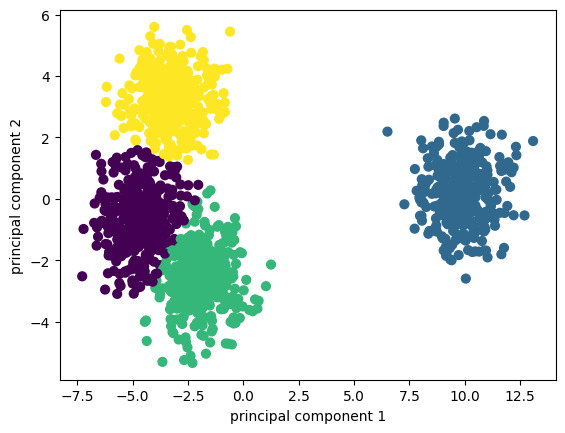

[[ 0.73282725 -0.68041474]
 [-0.68041474 -0.73282725]]


In [25]:
# Generate sample data
X, y = make_blobs(n_samples=1453, centers=4, random_state=1234)
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm.predict(X), s=40, cmap='viridis')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

# Get the projection axes
proj_axes = pca.components_
print(proj_axes)


#Describing Segments

In [ ]:
k4 = MD_k4.predict(MD_x)
table = pd.crosstab(k4, MD.Like)
sns.mosaicplot(table, shade=True)
plt.xlabel("segment number")
plt.show()

In [ ]:
k4 = MD_k4.predict(X) # Assuming X is the data used in clustering
mosaic(MD.groupby([k4, 'Gender']).size().reset_index().rename(columns={0:'count'}),
       index=['Gender', k4], gap=0.01, title='Cluster Distribution by Gender')
plt.show()

In [ ]:
from partykit import ctree
from formula import Formula

formula = Formula('factor(k4 == 3) ~ Like.n + Age + VisitFrequency + Gender')
tree = ctree(formula=formula, data=mcdonalds)
plot(tree)


#Selecting (the) Target Segment(s)

In [ ]:
visit = MD.groupby(k4)['VisitFrequency'].mean()

In [ ]:
like = MD.groupby(k4)['Like.n'].mean()
print(like)

In [ ]:
# Compute means by cluster
means = MD.groupby(k4).agg({
    'VisitFrequency': 'mean',
    'Like.n': 'mean',
    'Gender': lambda x: sum(x == 'Female') / len(x)
})

# Print results
print(means)

In [ ]:
visit = np.array([MD[MD['Cluster'] == i]['VisitFrequency'].mean() for i in range(1, 5)])
like = np.array([MD[MD['Cluster'] == i]['Like.n'].mean() for i in range(1, 5)])
female = np.array([MD[(MD['Cluster'] == i) & (MD['Gender'] == 'Female')].shape[0] / MD[MD['Cluster'] == i].shape[0] for i in range(1, 5)])

plt.plot(visit, like, 'bo', markersize = 10 * female)
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.xlabel('VisitFrequency')
plt.ylabel('Like.n')

for i in range(4):
    plt.text(visit[i], like[i], i + 1, ha = 'center', va = 'center')
    
plt.show()
